In [1]:
%pylab inline
%load_ext rpy2.ipython

import pandas as pd
import numpy as np

Populating the interactive namespace from numpy and matplotlib


# Infer behavior for agents

https://stats.stackexchange.com/questions/45538/how-to-generate-predicted-survivor-curves-from-frailty-models-using-r-coxph



In [30]:
datafilename = "../results-anonymized/pilot/pilot_20200505-7_block_3_hazard_table.csv"

df = pd.read_csv(datafilename)

In [2]:
datafilename1 = "../results-anonymized/pilot/pilot_20200505-7_block_1_hazard_table.csv"
datafilename2 = "../results-anonymized/pilot/pilot_20200505-7_block_2_hazard_table.csv"
datafilename3 = "../results-anonymized/pilot/pilot_20200505-7_block_3_hazard_table.csv"

In [39]:
%%R -i datafilename1 -i datafilename2 -i datafilename3 -o r1_summary -o r1_fit -o r1_survfit

# first fit without the frailty term to get a mean survival curve

# Running R in a python notebook: https://stackoverflow.com/a/41889995/6361632
# In this cell, use the R package 'survival'
# perform a cox regression on the whole experiment
# https://cran.r-project.org/web/packages/survival/vignettes/timedep.pdf
# https://www.rdocumentation.org/packages/survival/versions/3.1-7/topics/coxph
# https://www.rdocumentation.org/packages/survival/versions/3.1-7/topics/frailty


library(survival)
# library(survminer)

df1 <- read.csv(file=datafilename1, header=TRUE, stringsAsFactors=TRUE)
df2 <- read.csv(file=datafilename2, header=TRUE, stringsAsFactors=TRUE)
df3 <- read.csv(file=datafilename3, header=TRUE, stringsAsFactors=TRUE)
df <- rbind(df1,df2,df3)
df = subset(df, is_in_leads == 0)
df = subset(df, n_exposures > 0)
#df$leads2 = df$n_existing_leads**2

print(dim(df))
print(dim(df1))


[1] 85789    23
[1] 76261    23


# Shape of baseline adoption curve without frailty terms

Call:
coxph(formula = Surv(time = start, time2 = stop, event = adopt_event, 
    type = "counting") ~ n_exposures + is_spoke + is_in_deads + 
    n_rim_connections + n_triangle_paths, data = df)

  n= 52909, number of events= 2187 

                      coef exp(coef) se(coef)       z Pr(>|z|)    
n_exposures        0.23424   1.26395  0.05411   4.329 1.50e-05 ***
is_spoke           0.79813   2.22138  0.04975  16.041  < 2e-16 ***
is_in_deads       -0.98532   0.37332  0.08460 -11.646  < 2e-16 ***
n_rim_connections  0.24253   1.27447  0.01372  17.673  < 2e-16 ***
n_triangle_paths   0.16850   1.18352  0.03351   5.027 4.97e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                  exp(coef) exp(-coef) lower .95 upper .95
n_exposures          1.2639     0.7912    1.1368    1.4054
is_spoke             2.2214     0.4502    2.0150    2.4489
is_in_deads          0.3733     2.6787    0.3163    0.4407
n_rim_connections    1.2745     0.7846    1.2406    1.3092
n_

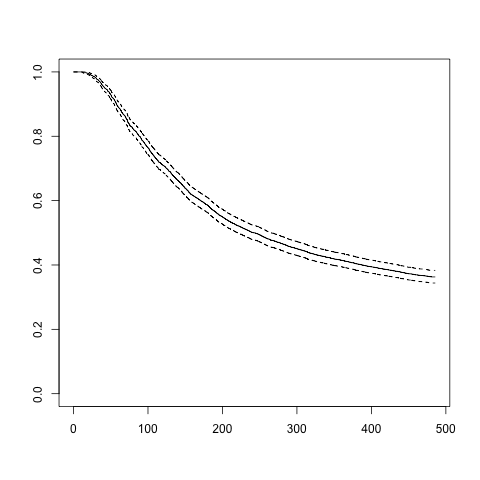

In [17]:
%%R -i datafilename1 -i datafilename2 -i datafilename3 -o r1_summary -o r1_fit -o r1_survfit

library(survival)
# library(survminer)

df1 <- read.csv(file=datafilename1, header=TRUE, stringsAsFactors=TRUE)
df2 <- read.csv(file=datafilename2, header=TRUE, stringsAsFactors=TRUE)
df3 <- read.csv(file=datafilename3, header=TRUE, stringsAsFactors=TRUE)
df <- rbind(df1,df2,df3)
#df <- rbind(df2,df3)
df = subset(df, is_in_leads == 0)
df = subset(df, n_exposures > 0)
df = subset(df, is_caveman_game == 0)
#df$n_leads2 = df$n_existing_leads**2
#df$t2 = df$start**2
#print(head(df))

r1_fit <- coxph(Surv(time=start, time2=stop, event=adopt_event, type='counting') ~ 
                    n_exposures + 
#                    in_startup_period + 
#                   is_link +
#                   is_spur + 
                    is_spoke +
                    is_in_deads +
                    n_rim_connections +
#                    n_existing_leads +
#                    n_leads2 +
#                    t2 + 
                    n_triangle_paths,
                data=df,
               )



#r1_survfit = survfit(r1_fit, newdata)
r1_survfit = survfit(r1_fit)
plot(r1_survfit, conf.int=TRUE)
#plot(survfit(r1_fit))

#print(predict(r1_fit, type='lp'))
# ggsurvplot(survfit(r1_fit), color = "#2E9FDF",
#            ggtheme = theme_minimal())

# print(survfit(r1_fit, list(n_exposures=1, in_startup_period=0, 
#                            is_link_or_spur=0, is_spoke=0, 
#                            is_in_deads=0, n_rim_connections=0,
#                            n_existing_leads=10)))
#print(r1_fit)

r1_summary = summary(r1_fit)
print(r1_summary)

In [4]:
fitdict = {i:j for i, j in r1_survfit.items()}

outdf = pd.DataFrame(index=fitdict['time'])
for col in ['surv', 'upper', 'lower', 'std.err']:
    outdf[col] = fitdict[col]
outdf            

,surv,upper,lower,std.err
12.860,0.997649,1.000000,0.989941,0.003957
16.510,0.995313,1.000000,0.981435,0.007164
16.928,0.992991,1.000000,0.973081,0.010334
18.610,0.992991,1.000000,0.973081,0.010334
19.649,0.990667,1.000000,0.964784,0.013508
...,...,...,...,...
480.867,0.304406,0.334289,0.277195,0.047778
480.928,0.304330,0.334206,0.277125,0.047778
481.107,0.304255,0.334123,0.277056,0.047779
481.111,0.304180,0.334041,0.276988,0.047779


In [5]:
resampled = pd.concat([outdf,outdf.reindex(range(500))]).sort_index().interpolate(method="linear").loc[range(500)]
resampled.fillna(1, inplace=True)
resampled = resampled.loc[~resampled.index.duplicated(keep='first')] # remove possible duplicate indices
resampled.loc[resampled['std.err']==1, 'std.err'] = 0

# smoothed hazard
resampled['hazard'] = (resampled['surv'].diff().abs().rolling(20,center=True).mean() / 
                       resampled['surv'].abs().rolling(20,center=True).mean() ).fillna(0)

resampled.to_csv('adopt_hazard.csv')
resampled.loc[100:150]

,surv,upper,lower,std.err,hazard
100.0,0.622888,0.692838,0.560001,0.054301,0.005863
101.0,0.618083,0.687256,0.555873,0.054125,0.005989
102.0,0.614302,0.682868,0.552620,0.053988,0.005865
103.0,0.610574,0.678546,0.549411,0.053854,0.005862
104.0,0.606429,0.673744,0.545839,0.053707,0.005769
105.0,0.602818,0.669565,0.542725,0.053579,0.005830
106.0,0.599745,0.666008,0.540076,0.053468,0.005841
107.0,0.597567,0.663488,0.538196,0.053391,0.005488
108.0,0.594981,0.660498,0.535963,0.053299,0.005406
109.0,0.591596,0.656585,0.533039,0.053179,0.005407


# calculate factors with frailty

In [43]:
%%R -i datafilename1 -i datafilename2 -i datafilename3 -o r1_summary -o r1_fit -o r1_survfit

library(survival)
# library(survminer)

df1 <- read.csv(file=datafilename1, header=TRUE, stringsAsFactors=TRUE)
df2 <- read.csv(file=datafilename2, header=TRUE, stringsAsFactors=TRUE)
df3 <- read.csv(file=datafilename3, header=TRUE, stringsAsFactors=TRUE)
df <- rbind(df1,df2,df3)
df = subset(df, is_in_leads == 0)
df = subset(df, n_exposures > 0)

r1_fit <- coxph(Surv(time=start, time2=stop, event=adopt_event, type='counting') ~ 
                    n_exposures + 
                    in_startup_period + 
                    is_link_or_spur + 
                    is_spoke +
                    is_in_deads +
                    n_rim_connections +
                    n_existing_leads +
                    n_triangle_paths +
                    frailty.gaussian(player_id),  # random effect for players
                data=df,
               )


#print(r1_fit)

r1_summary = summary(r1_fit)
print(r1_summary)

Call:
coxph(formula = Surv(time = start, time2 = stop, event = adopt_event, 
    type = "counting") ~ n_exposures + in_startup_period + is_link_or_spur + 
    is_spoke + is_in_deads + n_rim_connections + n_existing_leads + 
    n_triangle_paths + frailty.gaussian(player_id), data = df)

  n= 85789, number of events= 3906 

                          coef      se(coef) se2      Chisq   DF    p       
n_exposures                0.497444 0.036611 0.036341  184.61   1.0  4.8e-42
in_startup_period          0.463557 0.661200 0.661149    0.49   1.0  4.8e-01
is_link_or_spur           -1.027636 0.102745 0.102529  100.04   1.0  1.5e-23
is_spoke                  -0.203878 0.097324 0.097125    4.39   1.0  3.6e-02
is_in_deads               -1.983320 0.067110 0.066772  873.40   1.0 5.9e-192
n_rim_connections          0.270947 0.011747 0.011666  532.03   1.0 1.0e-117
n_existing_leads           0.020241 0.005912 0.005585   11.72   1.0  6.2e-04
n_triangle_paths           0.008534 0.028532 0.028456    0.

In [44]:
fitdict2 = {i:j for i, j in r1_fit.items()}
fitdict2.keys()

dict_keys(['coefficients', 'var', 'var2', 'loglik', 'iter', 'linear.predictors', 'residuals', 'means', 'method', 'frail', 'fvar', 'df', 'df2', 'penalty', 'pterms', 'assign2', 'history', 'coxlist1', 'printfun', 'n', 'nevent', 'terms', 'assign', 'wald.test', 'concordance', 'y', 'timefix', 'formula', 'call'])

In [45]:
frail = np.array(fitdict2['frail'])
frail.var()

0.8644779977014889

In [46]:
fit = pd.DataFrame(index=list(fitdict2['assign'].names)[:-1])
fit['means'] = fitdict2['means']
fit['coef'] = fitdict2['coefficients']
fit.to_csv('adopt_factors.csv')
fit

,means,coef
n_exposures,1.194699,0.497444
in_startup_period,0.043292,0.463557
is_link_or_spur,0.653639,-1.027636
is_spoke,0.325380,-0.203878
is_in_deads,0.229820,-1.983320
n_rim_connections,1.455455,0.270947
n_existing_leads,10.379652,0.020241
n_triangle_paths,0.168273,0.008534


# estimate drop hazard

Call:
coxph(formula = Surv(time = start, time2 = stop, event = forget_event, 
    type = "counting") ~ n_exposures + in_startup_period + is_link_or_spur + 
    is_spoke + n_rim_connections + n_existing_leads + n_triangle_paths, 
    data = df)

  n= 49849, number of events= 490 

                       coef exp(coef)  se(coef)      z Pr(>|z|)    
n_exposures       -0.305036  0.737097  0.058177 -5.243 1.58e-07 ***
in_startup_period        NA        NA  0.000000     NA       NA    
is_link_or_spur    2.518688 12.412305  0.465029  5.416 6.09e-08 ***
is_spoke           1.486893  4.423332  0.438488  3.391 0.000696 ***
n_rim_connections -0.290894  0.747595  0.035161 -8.273  < 2e-16 ***
n_existing_leads  -0.046564  0.954503  0.009124 -5.104 3.33e-07 ***
n_triangle_paths  -0.125564  0.882000  0.106593 -1.178 0.238809    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                  exp(coef) exp(-coef) lower .95 upper .95
n_exposures          0.7371    1.35667    0.6577

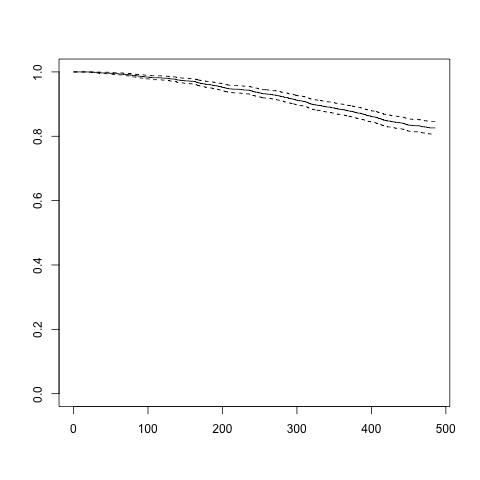

In [55]:
%%R -i datafilename1 -i datafilename2 -i datafilename3 -o r1_summary -o r1_fit -o r1_survfit

library(survival)
# library(survminer)

df1 <- read.csv(file=datafilename1, header=TRUE, stringsAsFactors=TRUE)
df2 <- read.csv(file=datafilename2, header=TRUE, stringsAsFactors=TRUE)
df3 <- read.csv(file=datafilename3, header=TRUE, stringsAsFactors=TRUE)
#df <- rbind(df1,df2,df3)
df <- rbind(df1,df3)
df = subset(df, is_in_deads == 0)
df = subset(df, is_in_leads == 1)



r1_fit <- coxph(Surv(time=start, time2=stop, event=forget_event, type='counting') ~ 
                    n_exposures + 
                    in_startup_period + 
                    is_link_or_spur + 
                    is_spoke +
                    n_rim_connections +
                    n_existing_leads +
                    n_triangle_paths,
                data=df,
                #id=exposure_id
               )

#r1_survfit = survfit(r1_fit, newdata)
r1_survfit = survfit(r1_fit)
plot(r1_survfit, conf.int=TRUE)
#plot(survfit(r1_fit))

#print(predict(r1_fit, type='lp'))
# ggsurvplot(survfit(r1_fit), color = "#2E9FDF",
#            ggtheme = theme_minimal())

# print(survfit(r1_fit, list(n_exposures=1, in_startup_period=0, 
#                            is_link_or_spur=0, is_spoke=0, 
#                            is_in_deads=0, n_rim_connections=0,
#                            n_existing_leads=10)))
#print(r1_fit)

r1_summary = summary(r1_fit)
print(r1_summary)

In [56]:
fitdict = {i:j for i, j in r1_survfit.items()}

outdf = pd.DataFrame(index=fitdict['time'])
for col in ['surv', 'upper', 'lower', 'std.err']:
    outdf[col] = fitdict[col]
outdf            

,surv,upper,lower,std.err
11.553,1.000000,1.000000,1.000000,0.000000
12.860,1.000000,1.000000,1.000000,0.000000
16.510,1.000000,1.000000,1.000000,0.000000
16.928,1.000000,1.000000,1.000000,0.000000
17.213,1.000000,1.000000,1.000000,0.000000
...,...,...,...,...
480.928,0.826124,0.845655,0.807043,0.011922
481.107,0.826124,0.845655,0.807043,0.011922
481.111,0.826124,0.845655,0.807043,0.011922
485.023,0.826124,0.845655,0.807043,0.011922


In [57]:
resampled = pd.concat([outdf,outdf.reindex(range(500))]).sort_index().interpolate(method="linear").loc[range(500)]
resampled.fillna(1, inplace=True)
resampled = resampled.loc[~resampled.index.duplicated(keep='first')] # remove possible duplicate indices
resampled.loc[resampled['std.err']==1, 'std.err'] = 0

# smoothed hazard
resampled['hazard'] = (resampled['surv'].diff().abs().rolling(20,center=True).mean() / 
                       resampled['surv'].abs().rolling(20,center=True).mean() ).fillna(0)
resampled.to_csv('forget_hazard.csv')

resampled.loc[100:150]

,surv,upper,lower,std.err,hazard
100.0,0.983999,0.989585,0.978444,0.002888,0.000234
101.0,0.983671,0.989329,0.978046,0.002926,0.000217
102.0,0.983507,0.989200,0.977847,0.002945,0.000217
103.0,0.983015,0.988813,0.977250,0.003001,0.000201
104.0,0.982687,0.988555,0.976853,0.003038,0.000184
105.0,0.982358,0.988296,0.976456,0.003075,0.000176
106.0,0.982030,0.988036,0.976060,0.003111,0.000167
107.0,0.982030,0.988036,0.976060,0.003111,0.000150
108.0,0.982030,0.988036,0.976060,0.003111,0.000134
109.0,0.982030,0.988036,0.976060,0.003111,0.000134


In [60]:
%%R -i datafilename1 -i datafilename2 -i datafilename3 -o r1_summary -o r1_fit -o r1_survfit

library(survival)
# library(survminer)

df1 <- read.csv(file=datafilename1, header=TRUE, stringsAsFactors=TRUE)
df2 <- read.csv(file=datafilename2, header=TRUE, stringsAsFactors=TRUE)
df3 <- read.csv(file=datafilename3, header=TRUE, stringsAsFactors=TRUE)
#df <- rbind(df1,df2,df3)
df <- rbind(df1,df3)
df = subset(df, is_in_deads == 0)
df = subset(df, is_in_leads == 1)

r1_fit <- coxph(Surv(time=start, time2=stop, event=forget_event, type='counting') ~ 
                    n_exposures + 
                    in_startup_period + 
                    is_link_or_spur + 
                    is_spoke +
                    n_rim_connections +
                    n_existing_leads +
                    n_triangle_paths +
                    frailty.gaussian(player_id),  # random effect for players
                data=df,
                #id=exposure_id
               )


#print(r1_fit)

r1_summary = summary(r1_fit)
print(r1_summary)

Call:
coxph(formula = Surv(time = start, time2 = stop, event = forget_event, 
    type = "counting") ~ n_exposures + in_startup_period + is_link_or_spur + 
    is_spoke + n_rim_connections + n_existing_leads + n_triangle_paths + 
    frailty.gaussian(player_id), data = df)

  n= 49849, number of events= 490 

                          coef     se(coef) se2     Chisq  DF    p      
n_exposures               -0.30908 0.06320  0.06208  23.92   1.0 1.0e-06
in_startup_period                  0.00000  0.00000          1.0        
is_link_or_spur            3.05838 0.47073  0.46783  42.21   1.0 8.2e-11
is_spoke                   1.77725 0.43871  0.43738  16.41   1.0 5.1e-05
n_rim_connections         -0.40392 0.03914  0.03803 106.53   1.0 5.7e-25
n_existing_leads          -0.01183 0.01390  0.01159   0.72   1.0 3.9e-01
n_triangle_paths          -0.39069 0.11690  0.11543  11.17   1.0 8.3e-04
frailty.gaussian(player_i                           533.98 106.7 4.5e-58

                  exp(coef) exp

In [61]:
fitdict2 = {i:j for i, j in r1_fit.items()}

In [62]:
fit = pd.DataFrame(index=list(fitdict2['assign'].names)[:-1])
fit['means'] = fitdict2['means']
fit['coef'] = fitdict2['coefficients']
fit.fillna(1, inplace=True)
fit.to_csv('forget_factors.csv')
fit

,means,coef
n_exposures,1.625328,-0.309080
in_startup_period,0.013982,1.000000
is_link_or_spur,0.534213,3.058384
is_spoke,0.424201,1.777254
n_rim_connections,4.239202,-0.403921
n_existing_leads,14.849766,-0.011831
n_triangle_paths,0.561355,-0.390688
